# Resume (CV) Parsing using Spacy 3


- https://spacy.io/
- Resume parsing technology converts an unstructured form of resume data into a structured format.
- A Resume Parser helps organizations eliminate the error-prone and time-consuming process and improves recruiters' efficiency.

### What is NER

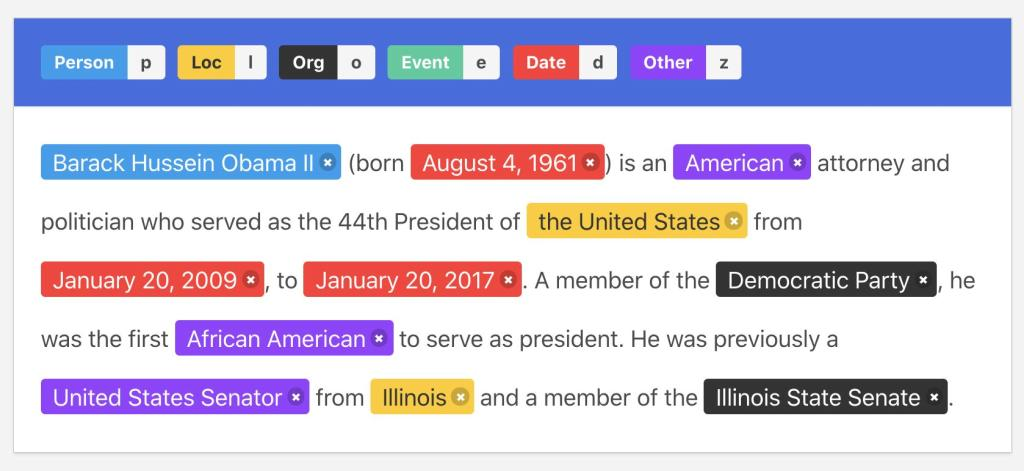

- It involves the identification of key information in the text and classification into a set of predefined categories.


## NER Training Preparation
- Download base `config` file from https://spacy.io/usage/training#quickstart
- Modify config file for training data
- Prepare training data
- Do training
- Final testing

Data
- https://github.com/laxmimerit
- https://github.com/laxmimerit/CV-Parsing-using-Spacy-3.git

## Data Annotation Tools


- doccano https://doccano.herokuapp.com/
- labelstudio https://labelstud.io/
- INCEpTION https://webanno.github.io/webanno/

In [ ]:
!pip install spacy_transformers
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 368 kB/s 
     |████████████████████████████████| 1.1 MB 60.5 MB/s 
     |████████████████████████████████| 4.2 MB 55.0 MB/s 
     |████████████████████████████████| 86 kB 1.3 MB/s 
     |████████████████████████████████| 6.6 MB 60.6 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json

In [ ]:
spacy.__version__

'3.3.1'

In [ ]:
!nvidia-smi

Fri Jun 17 19:51:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/laxmimerit/CV-Parsing-using-Spacy-3.git

Cloning into 'CV-Parsing-using-Spacy-3'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 82 (delta 16), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [ ]:
cv_data = json.load(open('/content/CV-Parsing-using-Spacy-3/data/training/train_data.json', 'r'))

In [ ]:
len(cv_data)

200

In [ ]:
!python -m spacy init fill-config /content/CV-Parsing-using-Spacy-3/data/training/base_config.cfg /content/CV-Parsing-using-Spacy-3/data/training/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/CV-Parsing-using-Spacy-3/data/training/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
# cv_data[0]

In [ ]:
def get_spacy_doc(file, data):
  nlp = spacy.blank('en')
  db = DocBin()

  for text, annot in tqdm(data):
    doc = nlp.make_doc(text)
    annot = annot['entities']

    ents = []
    entity_indices = []

    for start, end, label in annot:
      skip_entity = False
      for idx in range(start, end):
        if idx in entity_indices:
          skip_entity=True
          break
      if skip_entity==True:
        continue

      entity_indices = entity_indices + list(range(start, end))

      try:
        span = doc.char_span(start, end, label=label, alignment_mode='strict')
      except:
        continue

      if span is None:
        err_data = str([start, end]) + "    " + str(text) + "\n"
        file.write(err_data)

      else:
        ents.append(span)

    try:
      doc.ents = ents
      db.add(doc)
    except:
      pass

  return db
      

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(cv_data, test_size=0.3)

In [ ]:
len(train), len(test)

(140, 60)

In [ ]:
file = open('error.txt', 'w')

db = get_spacy_doc(file, train)
db.to_disk('train_data.spacy')

db = get_spacy_doc(file, test)
db.to_disk('test_data.spacy')

file.close()

100%|██████████| 60/60 [00:00<00:00, 86.78it/s]


In [ ]:
len(db.tokens)

60

In [ ]:
!python -m spacy train /content/CV-Parsing-using-Spacy-3/data/training/config.cfg --output ./output --paths.train ./train_data.spacy --paths.dev ./test_data.spacy --gpu-id 0

ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-06-17 20:10:05,414] [INFO] Set up nlp object from config
[2022-06-17 20:10:05,424] [INFO] Pipeline: ['transformer', 'ner']
[2022-06-17 20:10:05,428] [INFO] Created vocabulary
[2022-06-17 20:10:05,429] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a 

### Model Test

In [ ]:
nlp = spacy.load('/content/output/model-best')


In [ ]:
doc = nlp('my name is Laxmi Kant Tiwari. I worked at Microsoft. I have 10 years of experience')
for ent in doc.ents:
  print(ent.text, "   ->>>>> ", ent.label_)

Laxmi Kant    ->>>>>  Name
Microsoft    ->>>>>  Companies worked at
10 years    ->>>>>  Years of Experience


In [ ]:
!pip install PyMuPDF

In [ ]:
import sys, fitz

In [ ]:
fname = '/content/CV-Parsing-using-Spacy-3/data/test/Alice Clark CV.pdf'
doc = fitz.open(fname)

In [ ]:
# doc = [page.getText() for page in doc]

In [ ]:
text = " "
for page in doc:
  text = text + str(page.get_text())

In [ ]:
text = text.strip()

In [ ]:
text = ' '.join(text.split())

In [ ]:
text

'Alice Clark AI / Machine Learning Delhi, India Email me on Indeed • 20+ years of experience in data handling, design, and development • Data Warehouse: Data analysis, star/snow flake scema data modelling and design specific to data warehousing and business intelligence • Database: Experience in database designing, scalability, back-up and recovery, writing and optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes. Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure, Stream Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake analytics(U-SQL) Willing to relocate anywhere WORK EXPERIENCE Software Engineer Microsoft – Bangalore, Karnataka January 2000 to Present 1. Microsoft Rewards Live dashboards: Description: - Microsoft rewards is loyalty program that rewards Users for browsing and shopping online. Microsoft Rewards members can earn points when searching with Bing, browsing with Microsoft Edg

In [ ]:
doc = nlp(text)
for ent in doc.ents:
  print(ent.text, "   ->>>>> ", ent.label_)

Alice Clark    ->>>>>  Name
AI / Machine Learning    ->>>>>  Degree
Delhi    ->>>>>  Location
• 20    ->>>>>  Degree
• Data    ->>>>>  Degree
• Database    ->>>>>  Degree
Microsoft    ->>>>>  Companies worked at
Software Engineer    ->>>>>  Designation
Microsoft    ->>>>>  Companies worked at
– Bangalore,    ->>>>>  Degree
Microsoft    ->>>>>  Companies worked at
Microsoft    ->>>>>  Companies worked at
Microsoft    ->>>>>  Companies worked at
Microsoft    ->>>>>  Companies worked at
Microsoft    ->>>>>  Companies worked at
Microsoft    ->>>>>  Companies worked at
Indian Institute of Technology    ->>>>>  College Name
– Mumbai    ->>>>>  Degree
Machine Learning, Natural Language Processing, and Big Data Handling ADDITIONAL INFORMATION Professional Skills • Excellent analytical, problem solving, communication, knowledge transfer and interpersonal skills with ability to interact with individuals at all the levels • Quick learner and maintains cordial relationship with project manager and